# Estudos sobre acidentes de trânsito

Este notebook é um estudo livre sobre os acidentes de trânsito. O objetivo é testar diversos tipos de transformações nos dados, além de modelos de machine learning para prever a variável classificacao_acidente, que visa mostrar se houve ou não vítimas em um acidente.

A ideia geral é que eu aprender mais sobre ML, então, se alguém estiver lendo isso, saiba que não sou um grand master kaggle! 

Dados dos acidentes baixados no link:
https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes

Dicionário de dados - acidentes:
https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dicionario-acidentes

Dados do código de municípios do IBGE baixado no link:
https://www.ibge.gov.br/explica/codigos-dos-municipios.php

Serão utilizados apenas os dados do estado de minas gerais, uma vez que o dataset possui dados de todos os estados.

# Bibliotecas

In [28]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
#accuracy_score(y, p)

In [2]:
# Altera o tipo as opções de exibição para exibir todas as colunas
pd.set_option('display.max_columns', None)

In [3]:
# Realiza a leitura dos dados e exibe as primeiras linhas
dados_acidentes = pd.read_csv("datatran2021.csv", sep=";", encoding='ansi')

# Exibe as primeiras linhas
dados_acidentes.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,331693,2021-01-01,sexta-feira,00:02:00,SC,101.0,"314,9",LAGUNA,Ingestão de álcool pelo condutor,Colisão traseira,Com Vítimas Feridas,Plena Noite,Crescente,Nublado,Dupla,Reta,Não,3,0,1,0,2,0,1,2,-28.430294,-48.849251,SR-SC,UOP01,DEL02
1,331694,2021-01-01,sexta-feira,00:15:00,PR,376.0,188,MARIALVA,Velocidade Incompatível,Colisão com objeto,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,2,0,0,0,2,1,-23.466349,-51.828080,SR-PR,UOP01,DEL09
2,331696,2021-01-01,sexta-feira,00:00:00,SP,116.0,"110,6",TAUBATE,Demais falhas mecânicas ou elétricas,Incêndio,Sem Vítimas,Plena Noite,Crescente,Nublado,Dupla,Reta,Sim,1,0,0,0,1,0,0,1,-23.034126,-45.552700,SR-SP,UOP01,DEL06
3,331699,2021-01-01,sexta-feira,01:20:00,SC,101.0,111,NAVEGANTES,Manobra de mudança de faixa,Colisão lateral,Com Vítimas Feridas,Plena Noite,Crescente,Nublado,Múltipla,Curva,Sim,3,0,2,0,1,0,2,2,-26.839557,-48.714181,SR-SC,UOP04,DEL04
4,331701,2021-01-01,sexta-feira,00:30:00,PE,101.0,"45,1",IGARASSU,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Plena Noite,Decrescente,Chuva,Múltipla,Desvio Temporário,Sim,2,0,0,1,1,0,1,2,-7.865213,-34.907152,SR-PE,UOP02,DEL01


In [4]:
# Realiza leitura dos dados de municípios do IBGE
dados_municipios = pd.read_excel('RELATORIO_DTB_BRASIL_MUNICIPIO.xls')

dados_municipios_mg = dados_municipios[dados_municipios['Nome_UF'] == 'Minas Gerais']

In [5]:
# Checa a quantidade de valores por estado.
dados_acidentes.value_counts("uf")

uf
MG    7535
SC    7124
PR    6599
RJ    4165
RS    4114
SP    3890
BA    3016
GO    2905
ES    2335
PE    2317
MT    1982
MS    1482
CE    1408
PB    1310
RO    1300
RN    1210
MA    1037
PI    1037
DF     898
PA     770
AL     532
SE     466
TO     454
RR     237
AC     231
AP     158
AM      88
dtype: int64

Conforme identificado através do value counts, o estado de MG é o que teve o maior número de acidentes. Sendo assim, serão  utilizados os dados para o treinamento e teste dos algorítimos

In [6]:
dados_acidentes_mg = dados_acidentes[dados_acidentes['uf'] == 'MG']
dados_acidentes_mg.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
10,331708,2021-01-01,sexta-feira,01:00:00,MG,116.0,"79,1",MEDINA,Condutor Dormindo,Saída de leito carroçável,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Dupla,Não Informado,Não,1,0,0,0,1,0,0,1,-16.273886,-41.482124,SR-MG,UOP02,DEL11
24,331725,2021-01-01,sexta-feira,04:15:00,MG,116.0,"413,4",GOVERNADOR VALADARES,Velocidade Incompatível,Capotamento,Com Vítimas Fatais,Amanhecer,Crescente,Céu Claro,Simples,Reta,Sim,3,1,2,0,0,0,2,1,-18.873907,-41.966366,SR-MG,UOP01,DEL06
30,331731,2021-01-01,sexta-feira,05:50:00,MG,40.0,439,PARAOPEBA,Velocidade Incompatível,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Não Informado,Não,2,0,2,0,0,0,2,1,-19.231004,-44.435622,SR-MG,UOP01,DEL02
45,331791,2021-01-01,sexta-feira,03:50:00,MG,116.0,"464,6",TARUMIRIM,Demais falhas mecânicas ou elétricas,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Nublado,Simples,Reta,Não,1,0,1,0,0,0,1,1,-19.268652,-42.065696,SR-MG,UOP02,DEL06
52,331800,2021-01-01,sexta-feira,08:30:00,MG,381.0,913,CAMANDUCAIA,Velocidade Incompatível,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Chuva,Dupla,Não Informado,Não,1,0,1,0,0,0,1,1,-22.753900,-46.146503,SR-MG,UOP03,DEL16


In [7]:
print("Formato do dataset:", dados_acidentes_mg.shape)


Formato do dataset: (7535, 30)


## Separação e escolha de variáveis

Após ter os dados em mãos, serão feitas escolhas de algumas variáveis para tratar e iniciar os trabalhos.

In [8]:
# Selecionando um acidente em específico para entender melhor os dados.
dados_acidentes_mg[dados_acidentes_mg['id'] == 331725]

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
24,331725,2021-01-01,sexta-feira,04:15:00,MG,116.0,"413,4",GOVERNADOR VALADARES,Velocidade Incompatível,Capotamento,Com Vítimas Fatais,Amanhecer,Crescente,Céu Claro,Simples,Reta,Sim,3,1,2,0,0,0,2,1,-18.873907,-41.966366,SR-MG,UOP01,DEL06


Sabendo que vamos prever a classe classificacao_acidente, que indica se houve vítimas ou não, não faz sentido manter os campos 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados' e 'feridos'. Serão mantidos os campos pessoas e veículos.

O campo de 'horario' será removido uma vez que podemos utilizar o campo 'fase_dia' para se referir ao período do dia. Também será removido o campo UF, uma vez que são usados apenas os dados de Minas Gerais.

Latitude, longitude, regional, delegacia e uop serão ignorados, uma vez que temos outros campos para referenciar ao local do atendimento

In [9]:
# Cria lista com as colunas que serão mantidas
colunas = ['id', 'data_inversa', 'dia_semana', 'br', 'km', 'municipio', 'causa_acidente', 'tipo_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'pessoas', 'veiculos', 'classificacao_acidente']
dados_selecionados_acidentes_mg = dados_acidentes_mg[colunas]
dados_selecionados_acidentes_mg.head()

,id,data_inversa,dia_semana,br,km,municipio,causa_acidente,tipo_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,veiculos,classificacao_acidente
10,331708,2021-01-01,sexta-feira,116.0,"79,1",MEDINA,Condutor Dormindo,Saída de leito carroçável,Plena Noite,Decrescente,Céu Claro,Dupla,Não Informado,Não,1,1,Sem Vítimas
24,331725,2021-01-01,sexta-feira,116.0,"413,4",GOVERNADOR VALADARES,Velocidade Incompatível,Capotamento,Amanhecer,Crescente,Céu Claro,Simples,Reta,Sim,3,1,Com Vítimas Fatais
30,331731,2021-01-01,sexta-feira,40.0,439,PARAOPEBA,Velocidade Incompatível,Saída de leito carroçável,Pleno dia,Crescente,Céu Claro,Dupla,Não Informado,Não,2,1,Com Vítimas Feridas
45,331791,2021-01-01,sexta-feira,116.0,"464,6",TARUMIRIM,Demais falhas mecânicas ou elétricas,Saída de leito carroçável,Plena Noite,Crescente,Nublado,Simples,Reta,Não,1,1,Com Vítimas Feridas
52,331800,2021-01-01,sexta-feira,381.0,913,CAMANDUCAIA,Velocidade Incompatível,Saída de leito carroçável,Pleno dia,Crescente,Chuva,Dupla,Não Informado,Não,1,1,Com Vítimas Feridas


Depois de separar o dataset inicial, será feito o tratamento do segundo dataset que contém o código dos municípios do IBGE, que será utilizados para encodingo da variável município

In [10]:
# Remove dados desnecessários
dados_municipios_mg = dados_municipios_mg[['Código Município Completo', 'Nome_Município']]
dados_municipios_mg.rename(columns={'Código Município Completo': 'cod_ibge', 'Nome_Município': 'municipio'}, inplace=True)
dados_municipios_mg

,cod_ibge,municipio
2244,3100104,Abadia dos Dourados
2245,3100203,Abaeté
2246,3100302,Abre Campo
2247,3100401,Acaiaca
2248,3100500,Açucena
...,...,...
3092,3171808,Virginópolis
3093,3171907,Virgolândia
3094,3172004,Visconde do Rio Branco
3095,3172103,Volta Grande


Após finalizar a seleção das informações que serão usadas, os dados serão tratados para utilizar em algorítimos de ML

# Tratamento e transformação dos dados

Serão tratados os dados de muncípios primeiro, depois os dados do dataset de acidentes

In [11]:
# Checa como estão os nomes de municípios do dataset de acidentes
dados_selecionados_acidentes_mg.municipio.unique()

array(['MEDINA', 'GOVERNADOR VALADARES', 'PARAOPEBA', 'TARUMIRIM',
       'CAMANDUCAIA', 'SANTA LUZIA', 'ESMERALDAS', 'LEOPOLDINA',
       'IGARATINGA', 'SANTOS DUMONT', 'BETIM', 'ARAGUARI', 'CONTAGEM',
       'SAO JOAQUIM DE BICAS', 'PARACATU', 'SAO JOAO DO MANHUACU',
       'BARBACENA', 'ITAMBACURI', 'CARMOPOLIS DE MINAS', 'MATHIAS LOBATO',
       'ITATIAIUCU', 'NOVA SERRANA', 'TRES MARIAS', 'OLIVEIRA', 'IGARAPE',
       'SANTO ANTONIO DO AMPARO', 'PARA DE MINAS', 'PERDOES',
       'OLIVEIRA FORTES', 'UBERABA', 'CARMO DA CACHOEIRA',
       'SAO GONCALO DO PARA', 'CATUJI', 'SAO SEBASTIAO DA BELA VISTA',
       'UBERLANDIA', 'SETE LAGOAS', 'ITUIUTABA', 'PEDRA AZUL',
       'CONGONHAS', 'CAMPANHA', 'FELIXLANDIA', 'ARGIRITA', 'CAMBUI',
       'TEOFILO OTONI', 'PERIQUITO', 'CAREACU', 'ESTIVA', 'FRANCISCO SA',
       'PATOS DE MINAS', 'CAETE', 'POCOS DE CALDAS', 'LIMA DUARTE',
       'NOVA LIMA', 'ESTRELA DO SUL', 'PLANURA', 'FRUTAL', 'MURIAE',
       'ITAGUARA', 'JOAO PINHEIRO', 'BRUMADIN

Visto que as cidades no dataset de acidentes não possuem caracteres especiais, será necessário remover ou substituir eles no dataset de cidades para realizar o join

In [12]:
# Cria nova coluna, removendo acentos e colocando todas as letras em maiúsculo
dados_municipios_mg['nome_municipio'] = dados_municipios_mg['municipio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
dados_municipios_mg['nome_municipio'] = dados_municipios_mg['nome_municipio'].str.replace("'", "")

# Cria nova coluna normalizando os dados do código ibge
cod_ibge_scaler = StandardScaler()
dados_municipios_mg['cod_ibge_tratado'] = cod_ibge_scaler.fit_transform(dados_municipios_mg[['cod_ibge']])
dados_municipios_mg

# Neste trecho apliquei o StandarScaler para poder testar a funcionalidade e aprender seu uso.

,cod_ibge,municipio,nome_municipio,cod_ibge_tratado
2244,3100104,Abadia dos Dourados,ABADIA DOS DOURADOS,-1.780766
2245,3100203,Abaeté,ABAETE,-1.775985
2246,3100302,Abre Campo,ABRE CAMPO,-1.771204
2247,3100401,Acaiaca,ACAIACA,-1.766424
2248,3100500,Açucena,ACUCENA,-1.761643
...,...,...,...,...
3092,3171808,Virginópolis,VIRGINOPOLIS,1.681708
3093,3171907,Virgolândia,VIRGOLANDIA,1.686489
3094,3172004,Visconde do Rio Branco,VISCONDE DO RIO BRANCO,1.691173
3095,3172103,Volta Grande,VOLTA GRANDE,1.695954


In [13]:
# Mantém apenas o mês do campo data
dados_selecionados_acidentes_mg.loc[:,'data_inversa'] = pd.to_datetime(dados_selecionados_acidentes_mg['data_inversa'])
dados_selecionados_acidentes_mg['mes_acidente'] = dados_selecionados_acidentes_mg['data_inversa'].dt.month
dados_selecionados_acidentes_mg.drop(columns=['data_inversa'], axis=1, inplace=True)

C:\Users\Yuri Guerra\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-13-b33f77ee4f37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados_acidentes_mg['mes_acidente'] = dados_selecionados_acidentes_mg['data_inversa'].dt.month
C:\Users\Yuri Guerra\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [14]:
# Encoding das variáveis
le_dia_semana = LabelEncoder()
le_dia_semana.fit(dados_selecionados_acidentes_mg.dia_semana.unique())
dados_selecionados_acidentes_mg['le_dia_semana'] = le_dia_semana.transform(dados_selecionados_acidentes_mg['dia_semana'])

le_causa_acidente = LabelEncoder()
le_causa_acidente.fit(dados_selecionados_acidentes_mg.causa_acidente.unique())
dados_selecionados_acidentes_mg['le_causa_acidente'] = le_causa_acidente.transform(dados_selecionados_acidentes_mg['causa_acidente'])

le_tipo_acidente = LabelEncoder()
le_tipo_acidente.fit(dados_selecionados_acidentes_mg.tipo_acidente.unique())
dados_selecionados_acidentes_mg['le_tipo_acidente'] = le_tipo_acidente.transform(dados_selecionados_acidentes_mg['tipo_acidente'])

le_fase_dia = LabelEncoder()
le_fase_dia.fit(dados_selecionados_acidentes_mg.fase_dia.unique())
dados_selecionados_acidentes_mg['le_fase_dia'] = le_fase_dia.transform(dados_selecionados_acidentes_mg['fase_dia'])

le_sentido_via = LabelEncoder()
le_sentido_via.fit(dados_selecionados_acidentes_mg.sentido_via.unique())
dados_selecionados_acidentes_mg['le_sentido_via'] = le_sentido_via.transform(dados_selecionados_acidentes_mg['sentido_via'])

le_condicao_metereologica = LabelEncoder()
le_condicao_metereologica.fit(dados_selecionados_acidentes_mg.condicao_metereologica.unique())
dados_selecionados_acidentes_mg['le_condicao_metereologica'] = le_condicao_metereologica.transform(dados_selecionados_acidentes_mg['condicao_metereologica'])

le_tipo_pista = LabelEncoder()
le_tipo_pista.fit(dados_selecionados_acidentes_mg.tipo_pista.unique())
dados_selecionados_acidentes_mg['le_tipo_pista'] = le_tipo_pista.transform(dados_selecionados_acidentes_mg['tipo_pista'])

le_tracado_via = LabelEncoder()
le_tracado_via.fit(dados_selecionados_acidentes_mg.tracado_via.unique())
dados_selecionados_acidentes_mg['le_tracado_via'] = le_tracado_via.transform(dados_selecionados_acidentes_mg['tracado_via'])

le_uso_solo = LabelEncoder()
le_uso_solo.fit(dados_selecionados_acidentes_mg.uso_solo.unique())
dados_selecionados_acidentes_mg['le_uso_solo'] = le_uso_solo.transform(dados_selecionados_acidentes_mg['uso_solo'])

<ipython-input-14-62e0f79669d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados_acidentes_mg['le_dia_semana'] = le_dia_semana.transform(dados_selecionados_acidentes_mg['dia_semana'])
<ipython-input-14-62e0f79669d4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados_acidentes_mg['le_causa_acidente'] = le_causa_acidente.transform(dados_selecionados_acidentes_mg['causa_acidente'])
<ipython-input-14-62e0f79669d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a 

In [15]:
# Junta o dataset com o código da cidade no IBGE para concatenar no dataset de acidentes
dados_selecionados_acidentes_mg = dados_selecionados_acidentes_mg.merge(dados_municipios_mg[['nome_municipio', 'cod_ibge']], how='left', left_on='municipio', right_on='nome_municipio')

In [16]:
# Dropa coluna nome_municipio
dados_selecionados_acidentes_mg.drop(columns=['nome_municipio'], axis=1, inplace=True)

In [17]:
# Monta o dataframe apenas com os dados que serão utilizados nas previsões (X e y)
X = dados_selecionados_acidentes_mg[['mes_acidente', 'le_dia_semana', 'le_causa_acidente', 'le_tipo_acidente', 'le_fase_dia', 'le_sentido_via', 'le_condicao_metereologica', 'le_tipo_pista', 'le_tracado_via', 'le_uso_solo', 'cod_ibge']]
y = dados_selecionados_acidentes_mg['classificacao_acidente']

X.describe()


,mes_acidente,le_dia_semana,le_causa_acidente,le_tipo_acidente,le_fase_dia,le_sentido_via,le_condicao_metereologica,le_tipo_pista,le_tracado_via,le_uso_solo,cod_ibge
count,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7.535000e+03
mean,6.081752,2.989516,32.889449,9.571599,2.396284,0.487193,2.254147,1.030392,3.304711,0.315594,3.136714e+06
std,3.170361,2.025264,21.853267,5.036226,0.821361,0.502782,2.390648,0.978400,2.146740,0.464783,2.143132e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.100302e+06
25%,3.000000,1.000000,12.000000,6.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.118304e+06
50%,6.000000,3.000000,37.000000,9.000000,3.000000,0.000000,1.000000,1.000000,5.000000,0.000000,3.136702e+06
75%,9.000000,5.000000,57.000000,15.000000,3.000000,1.000000,4.000000,2.000000,5.000000,1.000000,3.154606e+06
max,11.000000,6.000000,62.000000,16.000000,3.000000,2.000000,8.000000,2.000000,9.000000,1.000000,3.171501e+06


In [18]:
X_ss = StandardScaler()
X =  X_ss.fit_transform(X)
X = pd.DataFrame(X, columns=['mes_acidente', 'le_dia_semana', 'le_causa_acidente', 'le_tipo_acidente', 'le_fase_dia', 'le_sentido_via', 'le_condicao_metereologica', 'le_tipo_pista', 'le_tracado_via', 'le_uso_solo', 'cod_ibge'])
X


,mes_acidente,le_dia_semana,le_causa_acidente,le_tipo_acidente,le_fase_dia,le_sentido_via,le_condicao_metereologica,le_tipo_pista,le_tracado_via,le_uso_solo,cod_ibge
0,-1.603000,0.498973,-0.910197,1.077942,-0.482504,1.020008,-0.524640,-1.053210,-0.141951,-0.679059,0.218891
1,-1.603000,0.498973,1.286417,-1.503527,-2.917648,-0.969060,-0.524640,0.991081,0.789756,1.472627,-0.420590
2,-1.603000,0.498973,1.286417,1.077942,0.735068,-0.969060,-0.524640,-1.053210,-0.141951,-0.679059,0.498733
3,-1.603000,0.498973,-0.498332,1.077942,-0.482504,-0.969060,1.566981,0.991081,0.789756,-0.679059,1.478953
4,-1.603000,0.498973,1.286417,1.077942,0.735068,-0.969060,-0.942965,-1.053210,-0.141951,-0.679059,-1.222834
...,...,...,...,...,...,...,...,...,...,...,...
7530,0.289654,-0.982414,0.828789,-0.113505,0.735068,-0.969060,1.985306,0.991081,0.789756,1.472627,-0.872949
7531,1.551424,-0.982414,-0.406806,-0.312080,0.735068,-0.969060,-0.524640,0.991081,-0.141951,-0.679059,-0.686200
7532,1.551424,-1.476209,-1.505113,-0.113505,-0.482504,-0.969060,1.566981,0.991081,0.789756,-0.679059,-1.096981
7533,-0.341230,-1.476209,-1.505113,-1.106378,0.735068,-0.969060,1.566981,0.991081,0.789756,-0.679059,-0.023668


# Treinamento e avaliação de modelos


Após preparar os dataset, relizo testes e alguns modelos e faço ajustes de alguns hiperparâmetros.
Não quero utilizar GridSearch para poder otimizar os algorítimos, pois a ideia é conhecer melhor os algorítimos e aprender a ajusta-los

## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Execução real com validação cruzada
kf = RepeatedKFold(n_splits=4, n_repeats=10, random_state=0)
params1 = {'n_estimators':50, 'criterion':'gini', 'n_jobs':1, 'random_state':0}
params2 = {'n_estimators':50, 'criterion':'entropy', 'n_jobs':1, 'random_state':0}
params3 = {'n_estimators':25, 'criterion':'gini', 'n_jobs':1, 'random_state':0}
params4 = {'n_estimators':25, 'criterion':'entropy', 'n_jobs':1, 'random_state':0}

resultados1 = []
resultados2 = []
resultados3 = []
resultados4 = []
for linhas_treino, linhas_valid in kf.split(X):
    # Separa o X e y de treinamento e validação
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid= y.iloc[linhas_treino], y.iloc[linhas_valid]

    # Treina o modelo com os parâmetros 1
    modelo_floresta = RandomForestClassifier(**params1)
    modelo_floresta.fit(X_treino,y_treino)
    p = modelo_floresta.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados1.append(acc)

    # Treina o modelo com os parâmetros 2
    modelo_floresta = RandomForestClassifier(**params2)
    modelo_floresta.fit(X_treino,y_treino)
    p = modelo_floresta.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados2.append(acc)

    # Treina o modelo com os parâmetros 3
    modelo_floresta = RandomForestClassifier(**params3)
    modelo_floresta.fit(X_treino,y_treino)
    p = modelo_floresta.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados3.append(acc)

    # Treina o modelo com os parâmetros 4
    modelo_floresta = RandomForestClassifier(**params4)
    modelo_floresta.fit(X_treino,y_treino)
    p = modelo_floresta.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados4.append(acc)

Média dos resultados do parâmetro 1:  0.7966954018128455
Média dos resultados do parâmetro 2:  0.7959656844173988
Média dos resultados do parâmetro 3:  0.7929662104109515
Média dos resultados do parâmetro 4:  0.7936164791017631


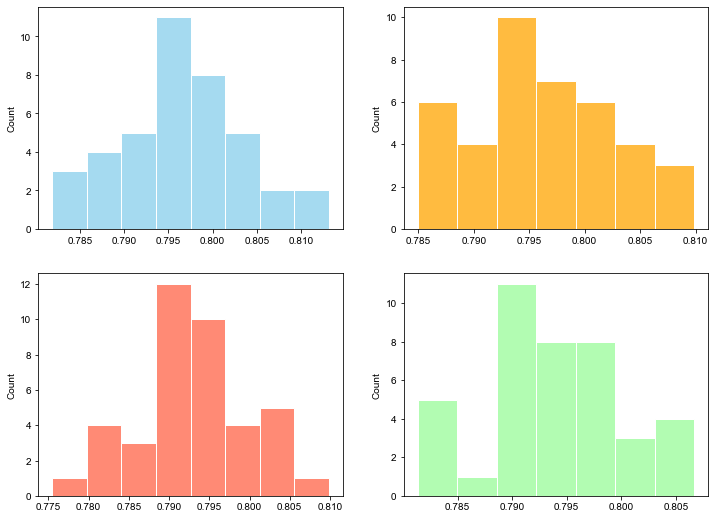

In [21]:
# Média das previsões
print('Média dos resultados do parâmetro 1: ', np.mean(resultados1))
print('Média dos resultados do parâmetro 2: ', np.mean(resultados2))
print('Média dos resultados do parâmetro 3: ', np.mean(resultados3))
print('Média dos resultados do parâmetro 4: ', np.mean(resultados4))

# plota histograma dos resultados
fig, axs = plt.subplots(2,2, figsize=(12,9))

sns.set(style="darkgrid")

sns.histplot(data=resultados1, color='skyblue', label='Parametro 1', ax=axs[0,0])
sns.histplot(data=resultados2, color="orange", label="Parametro 2", ax=axs[0,1])
sns.histplot(data=resultados3, color='tomato', label="Parametro 3", ax=axs[1,0])
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4", ax=axs[1,1])

plt.show()

Pela média geral e análise dos gráficos individualmente, podemos verificar que as configurações do parâmetro 1 apresentaram melhor desempenho geral que as demais configurações.

Para poder comparar os resultados, feita a comparação entre os histogramas

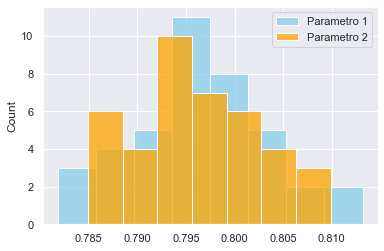

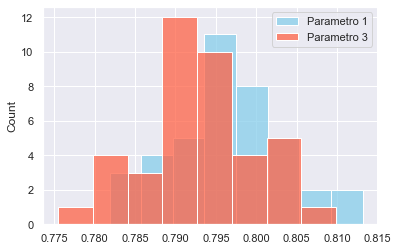

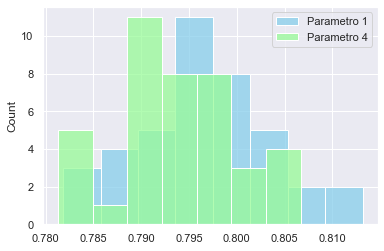

In [22]:
# Comparação parametros 1 e 2
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados2, color="orange", label="Parametro 2")
plt.legend()
plt.show()

# Comparação parametros 1 e 3
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados3, color='tomato', label="Parametro 3")
plt.legend()
plt.show()

# Comparação parametros 1 e 4
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4")
plt.legend()
plt.show()

Conforme verificado pelos histogramas, as configurações do parâmetro 1 apresentaram um melhor desempenho de maneira geral comparado aos demais, sendo assim definidos como as configurações a serem utilizadas para a random forest.

### Resultado médio final Random Forest: 79,66%

## SVM

In [23]:
from sklearn.svm import SVC

In [24]:
# Execução real com validação cruzada
kf = RepeatedKFold(n_splits=4, n_repeats=4, random_state=0)
params1 = {'kernel':'linear', 'C':1.0, 'random_state':0}
params2 = {'kernel':'poly', 'C':1.0, 'random_state':0}
params3 = {'kernel':'sigmoid', 'C':1.0, 'random_state':0}
params4 = {'kernel':'rbf', 'C':1.0, 'random_state':0}

resultados1 = []
resultados2 = []
resultados3 = []
resultados4 = []
for linhas_treino, linhas_valid in kf.split(X):
    # Separa o X e y de treinamento e validação
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid= y.iloc[linhas_treino], y.iloc[linhas_valid]

    # Treina o modelo com os parâmetros 1
    modelo_svm = SVC(**params1)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados1.append(acc)

    # Treina o modelo com os parâmetros 2
    modelo_svm = SVC(**params2)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados2.append(acc)

    # Treina o modelo com os parâmetros 3
    modelo_svm = SVC(**params3)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados3.append(acc)

    # Treina o modelo com os parâmetros 4
    modelo_svm = SVC(**params4)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados4.append(acc)

Média dos resultados do parâmetro 1:  0.7818183816988069
Média dos resultados do parâmetro 2:  0.7816856853081489
Média dos resultados do parâmetro 3:  0.6979091791512617
Média dos resultados do parâmetro 4:  0.7818183816988069


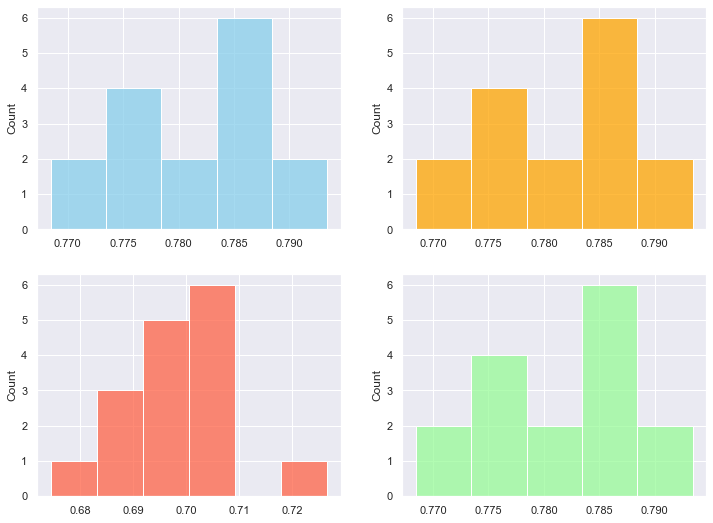

In [25]:
# Média das previsões
print('Média dos resultados do parâmetro 1: ', np.mean(resultados1))
print('Média dos resultados do parâmetro 2: ', np.mean(resultados2))
print('Média dos resultados do parâmetro 3: ', np.mean(resultados3))
print('Média dos resultados do parâmetro 4: ', np.mean(resultados4))

# plota histograma dos resultados
fig, axs = plt.subplots(2,2, figsize=(12,9))

sns.set(style="darkgrid")

sns.histplot(data=resultados1, color='skyblue', label='Parametro 1', ax=axs[0,0])
sns.histplot(data=resultados2, color="orange", label="Parametro 2", ax=axs[0,1])
sns.histplot(data=resultados3, color='tomato', label="Parametro 3", ax=axs[1,0])
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4", ax=axs[1,1])

plt.show()

Como o parâmetro 3 teve uma média muito inferior e os demais parâmetros tiveram resultados parecidos, serão feitas comparações dos resultados dos parametros 1, 2 e 4


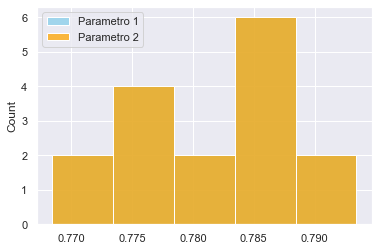

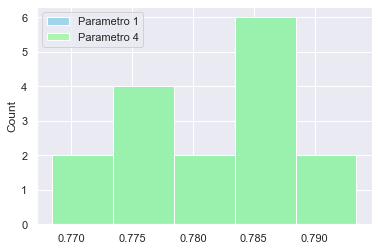

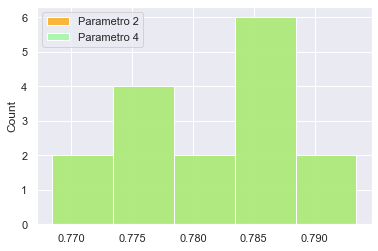

In [26]:
# Comparação parametros 1 e 2
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados2, color="orange", label="Parametro 2")
plt.legend()
plt.show()

# Comparação parametros 1 e 3
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4")
plt.legend()
plt.show()

# Comparação parametros 1 e 4
sns.histplot(data=resultados2, color='orange', label='Parametro 2')
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4")
plt.legend()
plt.show()

Conforme observadonas comparações, não houve diferenças significativas para mudança no kernel do SVM, a não ser para o kernel 'sigmoid', sendo assim, será considerado como vencedor o parâmetro 4 que possui o kernel 'rfb', pois é o kernel padrão.

Separando o kernel padrão, serão feitos testes com outros níveis para o parâmetro C, que indica a punição por erro.

In [50]:
# Execução real com validação cruzada
kf = RepeatedKFold(n_splits=4, n_repeats=4, random_state=0)
params1 = {'kernel':'rbf', 'C':1.0, 'random_state':0}
params2 = {'kernel':'rbf', 'C':3.0, 'random_state':0}
params3 = {'kernel':'rbf', 'C':5.0, 'random_state':0}

resultados1 = []
resultados2 = []
resultados3 = []
for linhas_treino, linhas_valid in kf.split(X):
    # Separa o X e y de treinamento e validação
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid= y.iloc[linhas_treino], y.iloc[linhas_valid]

    # Treina o modelo com os parâmetros 1
    modelo_svm = SVC(**params1)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados1.append(acc)

    # Treina o modelo com os parâmetros 2
    modelo_svm = SVC(**params2)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados2.append(acc)

    # Treina o modelo com os parâmetros 3
    modelo_svm = SVC(**params3)
    modelo_svm.fit(X_treino,y_treino)
    p = modelo_svm.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados3.append(acc)

Média dos resultados do parâmetro 1:  0.7818183816988069
Média dos resultados do parâmetro 2:  0.7818183816988069
Média dos resultados do parâmetro 3:  0.7818183816988069


<AxesSubplot:ylabel='Count'>

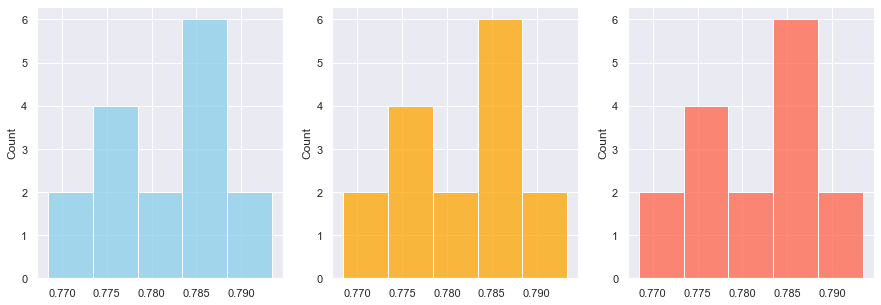

In [51]:
# Média das previsões
print('Média dos resultados do parâmetro 1: ', np.mean(resultados1))
print('Média dos resultados do parâmetro 2: ', np.mean(resultados2))
print('Média dos resultados do parâmetro 3: ', np.mean(resultados3))

# plota histograma dos resultados
fig, axs = plt.subplots(1,3, figsize=(15,5))

sns.set(style="darkgrid")

sns.histplot(data=resultados1, color='skyblue', label='Parametro 1', ax=axs[0])
sns.histplot(data=resultados2, color="orange", label="Parametro 2", ax=axs[1])
sns.histplot(data=resultados3, color='tomato', label="Parametro 3", ax=axs[2])

Observando a média geral, podemos observar que com a mudança do parâmetro C tivemos piores resultados a medida que aumentamos o mesmo. NO gráfico é possível observar que com C=1, conseguimos uma variação maior, enquanto que C=3 e C=5 não houve diferença significativa entre os dois.

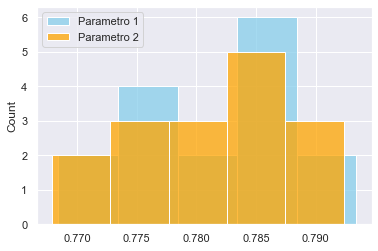

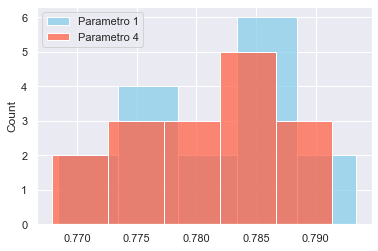

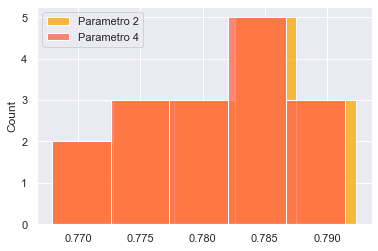

In [43]:
# Comparação parametros 1 e 2
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados2, color="orange", label="Parametro 2")
plt.legend()
plt.show()

# Comparação parametros 1 e 3
sns.histplot(data=resultados1, color='skyblue', label='Parametro 1')
sns.histplot(data=resultados3, color='tomato', label="Parametro 4")
plt.legend()
plt.show()

# Comparação parametros 1 e 4
sns.histplot(data=resultados2, color='orange', label='Parametro 2')
sns.histplot(data=resultados3, color='tomato', label="Parametro 4")
plt.legend()
plt.show()

Através da comparação dos histogramas, podemos observar que de modo geral o parâmetro C=1 possui um resultado melhor em relação aos demais, enquanto que C=3 apresenta uma resultado melhor em relação a C=5.

Em outros testes que havia feito, não identifiquei nenhuma mudança em valores de C<1

### Resultado médio final SVM: 78,18%

## Regressão logística

In [45]:
from sklearn.linear_model import LogisticRegression

In [54]:
# Execução real com validação cruzada
kf = RepeatedKFold(n_splits=4, n_repeats=10, random_state=0)
params1 = {'random_state':0, 'solver':'newton-cg'}
params2 = {'random_state':0, 'solver':'sag'}
params3 = {'random_state':0, 'solver':'saga'}
params4 = {'random_state':0, 'solver':'lbfgs'}

resultados1 = []
resultados2 = []
resultados3 = []
resultados4 = []

for linhas_treino, linhas_valid in kf.split(X):
    # Separa o X e y de treinamento e validação
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid= y.iloc[linhas_treino], y.iloc[linhas_valid]

    # Treina o modelo com os parâmetros 1
    modelo_logistic_regression = LogisticRegression(**params1)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados1.append(acc)

    # Treina o modelo com os parâmetros 2
    modelo_logistic_regression = LogisticRegression(**params2)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados2.append(acc)

    # Treina o modelo com os parâmetros 3
    modelo_logistic_regression = LogisticRegression(**params3)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados3.append(acc)

    # Treina o modelo com os parâmetros 4
    modelo_logistic_regression = LogisticRegression(**params4)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados4.append(acc)

Média dos resultados do parâmetro 1:  0.7818184874049068
Média dos resultados do parâmetro 2:  0.7818184874049068
Média dos resultados do parâmetro 3:  0.7818184874049068
Média dos resultados do parâmetro 4:  0.7818184874049068


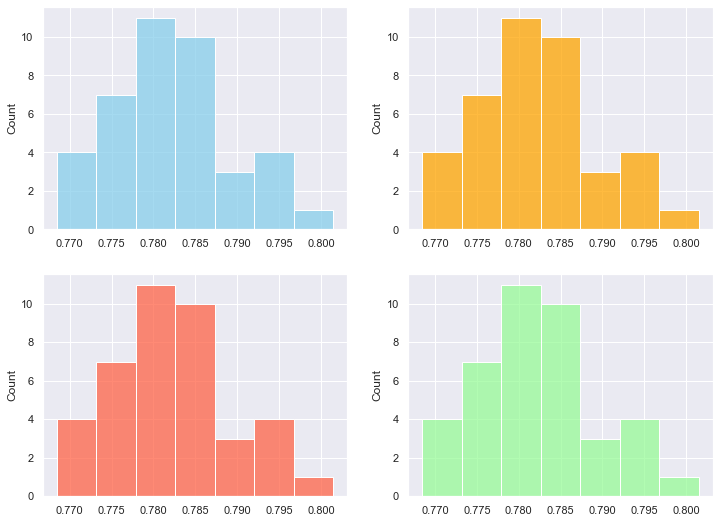

In [55]:
# Média das previsões
print('Média dos resultados do parâmetro 1: ', np.mean(resultados1))
print('Média dos resultados do parâmetro 2: ', np.mean(resultados2))
print('Média dos resultados do parâmetro 3: ', np.mean(resultados3))
print('Média dos resultados do parâmetro 4: ', np.mean(resultados4))

# plota histograma dos resultados
fig, axs = plt.subplots(2,2, figsize=(12,9))

sns.set(style="darkgrid")

sns.histplot(data=resultados1, color='skyblue', label='Parametro 1', ax=axs[0,0])
sns.histplot(data=resultados2, color="orange", label="Parametro 2", ax=axs[0,1])
sns.histplot(data=resultados3, color='tomato', label="Parametro 3", ax=axs[1,0])
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4", ax=axs[1,1])

plt.show()

Como não houve diferença entre as alterações do parâmetro solver, conforme observado pelas médias gerais e pelos histogramas, será feito um teste com a mudança do parâmetro C, utilizando o solver padrão lbfgs.

In [58]:
# Execução real com validação cruzada
kf = RepeatedKFold(n_splits=4, n_repeats=10, random_state=0)
params1 = {'random_state':0, 'solver':'lbfgs', 'C':0.01}
params2 = {'random_state':0, 'solver':'lbfgs', 'C':0.1}
params3 = {'random_state':0, 'solver':'lbfgs', 'C':0.5}
params4 = {'random_state':0, 'solver':'lbfgs', 'C':1}

resultados1 = []
resultados2 = []
resultados3 = []
resultados4 = []

for linhas_treino, linhas_valid in kf.split(X):
    # Separa o X e y de treinamento e validação
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid= y.iloc[linhas_treino], y.iloc[linhas_valid]

    # Treina o modelo com os parâmetros 1
    modelo_logistic_regression1 = LogisticRegression(**params1)
    modelo_logistic_regression1.fit(X_treino,y_treino)
    p = modelo_logistic_regression1.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados1.append(acc)

    # Treina o modelo com os parâmetros 2
    modelo_logistic_regression = LogisticRegression(**params2)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados2.append(acc)

    # Treina o modelo com os parâmetros 3
    modelo_logistic_regression = LogisticRegression(**params3)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados3.append(acc)

    # Treina o modelo com os parâmetros 4
    modelo_logistic_regression = LogisticRegression(**params4)
    modelo_logistic_regression.fit(X_treino,y_treino)
    p = modelo_logistic_regression.predict(X_valid)
    acc = np.mean(y_valid == p)
    resultados4.append(acc)

Média dos resultados do parâmetro 1:  0.7818184874049068
Média dos resultados do parâmetro 2:  0.7818184874049068
Média dos resultados do parâmetro 3:  0.7818184874049068
Média dos resultados do parâmetro 4:  0.7818184874049068


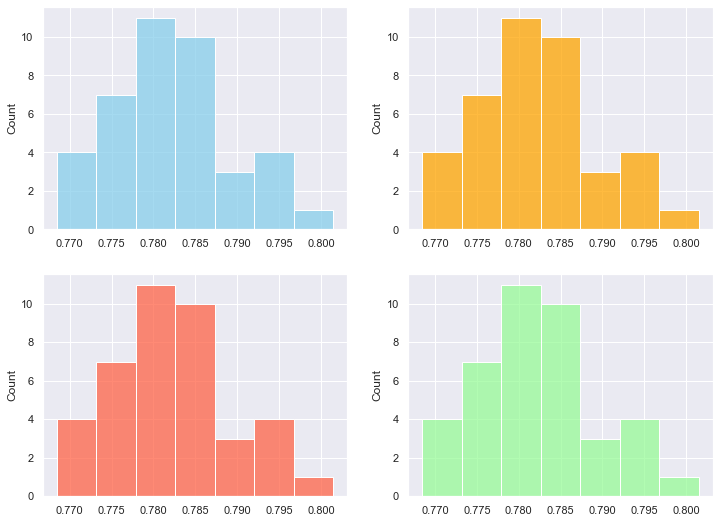

In [59]:
# Média das previsões
print('Média dos resultados do parâmetro 1: ', np.mean(resultados1))
print('Média dos resultados do parâmetro 2: ', np.mean(resultados2))
print('Média dos resultados do parâmetro 3: ', np.mean(resultados3))
print('Média dos resultados do parâmetro 4: ', np.mean(resultados4))

# plota histograma dos resultados
fig, axs = plt.subplots(2,2, figsize=(12,9))

sns.set(style="darkgrid")

sns.histplot(data=resultados1, color='skyblue', label='Parametro 1', ax=axs[0,0])
sns.histplot(data=resultados2, color="orange", label="Parametro 2", ax=axs[0,1])
sns.histplot(data=resultados3, color='tomato', label="Parametro 3", ax=axs[1,0])
sns.histplot(data=resultados4, color='palegreen', label="Parametro 4", ax=axs[1,1])

plt.show()

Como observado, mesmo alterando os níveis do parâmetro C, não houve ganho em relação ao resultado final. As médias e os histogramas permanecem os mesmos.

### Resultado final regressao logistica: 78,18%